<a href="https://colab.research.google.com/github/Orikson/MAT-421/blob/main/MAT421_Module_B_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpolation Problem Statement

Assume we have a set of independent data values $x_i$, and a set of dependent data values $y_i$. How can we estimate the value in between data values? Can we construct an estimation function $\hat y(x)$ on the domain of $x$ such that $\hat y(x_i) = y_i$ and $\hat y(x)$ is a reasonable estimator between provided values?

Note that such functions need not necessarily be on scalars. What if they operate on vectors?

Throughout this notebook, different interpolation techniques will be applied for both a 1D ($\hat f:\mathbb{R} \rightarrow \mathbb{R}$) and 2D ($\hat f:\mathbb{R} \rightarrow \mathbb{R}^2$) set of dependent values.

The first function is scalar $y$ as a function of $x$. The second function is vector $[x, y]$ as a function of $t$.

Feel free to change input data values in the below cell.

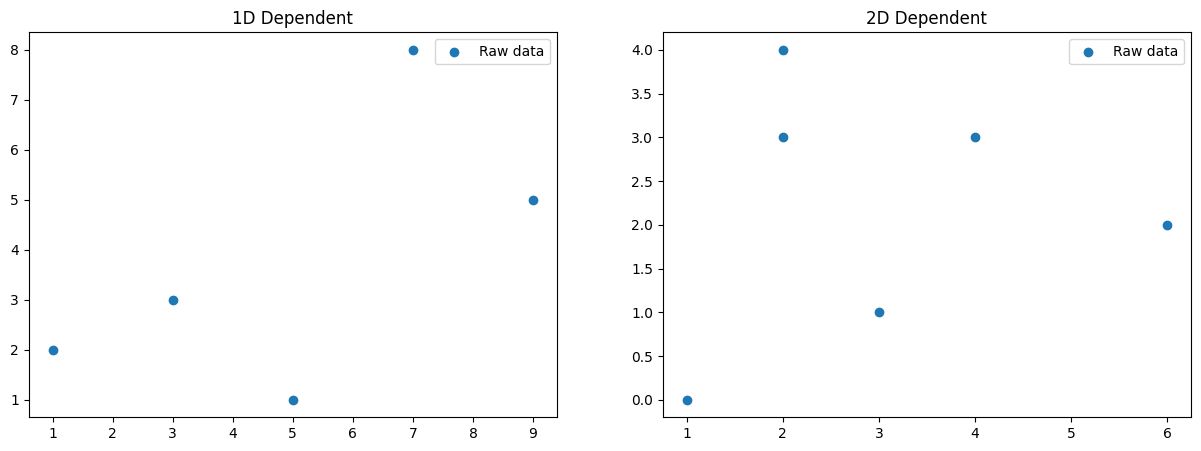

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Raw data
# Note that for consistency, all dependent variables, e.g. y, satisfy len(y.shape) == 2
x = np.array([1, 3, 5, 7, 9])
y = np.array([2, 3, 1, 8, 5])[:,None] # has shape (5,1)

t = np.array([0, 2, 4, 6, 8, 10])
r = np.transpose(np.array([[1, 3, 4, 2, 2, 6],    # has shape (6,2)
                           [0, 1, 3, 4, 3, 2]]))

# Points to interpolate at
xp = np.array([2, 4, 6, 8])
tp = np.array([1, 3, 5, 7, 9])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].scatter(x, *np.transpose(y), label="Raw data")
axs[0].legend()
axs[0].set_title('1D Dependent')
axs[1].scatter(*np.transpose(r), label="Raw data")
axs[1].legend()
axs[1].set_title('2D Dependent')

plt.show()

# Linear Interpolation

Linear interpolation, for some input value, takes the two nearest points in the independent dimension, plots a line between them, and returns the value associated with the input along that line.

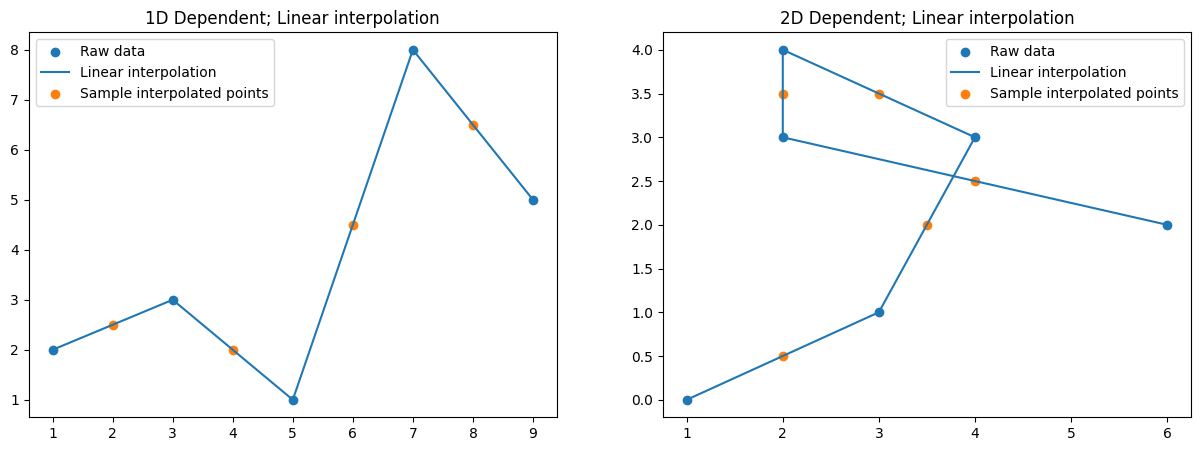

In [81]:
from bisect import bisect

class linear_interp:
  def __init__(self, x, y):
    '''
    x - independent variable
    y - dependent variable
    '''
    # sort y with respect to x
    ind = np.argsort(x)
    self.x = x[ind]
    self.y = y[ind]

  def __call__(self, xp):
    u = np.array([min(bisect(self.x, x), len(self.x)-1) for x in xp])
    l = u - 1

    xp = np.repeat(xp[:, None], self.y.shape[1], axis=1)
    xc = np.repeat(np.copy(self.x)[:, None], self.y.shape[1], axis=1)

    return self.y[l] + (self.y[u] - self.y[l]) * (xp - xc[l]) / (xc[u] - xc[l])

li_1 = linear_interp(x, y)
li_2 = linear_interp(t, r)

yp = li_1(xp)
rp = li_2(tp)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].scatter(x, *np.transpose(y), label="Raw data")
axs[0].plot(x, *np.transpose(y), label="Linear interpolation")
axs[0].scatter(xp, *np.transpose(yp), label="Sample interpolated points")
axs[0].legend()
axs[0].set_title('1D Dependent; Linear interpolation')
axs[1].scatter(*np.transpose(r), label="Raw data")
axs[1].plot(*np.transpose(r), label="Linear interpolation")
axs[1].scatter(*np.transpose(rp), label="Sample interpolated points")
axs[1].legend()
axs[1].set_title('2D Dependent; Linear interpolation')

plt.show()

# Cubic Spline Interpolation

Between each raw data point, instead of mapping a line between neighboring points, we plot a cubic function, and enforce boundary conditions that the resulting function must satisfy. We know that the cubic function should go through each data point, and we additionally introduce the constraint that the first and second derivatives between neighboring cubics must be equal. The remaining conditions for the boundary for there to exist a unique solution are more arbitrary; the textbook chooses to set the second derivative to 0 at each end point.

This means we develop a system of $4(n-1)$ equations (where $n$ is the number of data points) to solve for all $n-1$ cubic functions between data points.

All cubic functions have the form
$$f_i(x)=a_ix^3+b_ix^2+c_ix+d_i$$
$$f_i'(x)=3a_ix^2+2b_ix+c_i$$
$$f_i''(x)=6a_ix+2b_i$$

To solve for each cubic spline, we simply construct the linear system of constraints as a matrix, and then invert the matrix to evaluate for each cubic spline parameter.

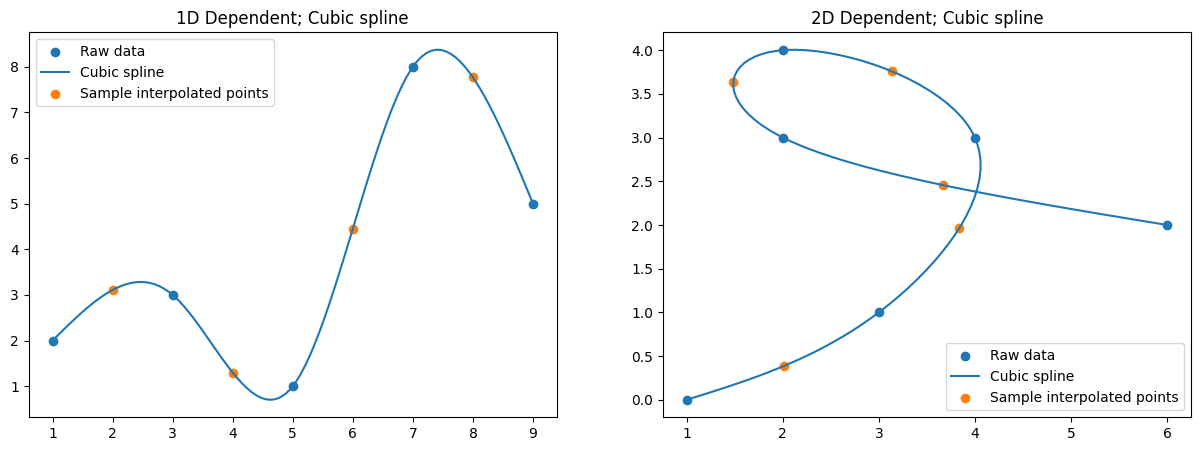

In [82]:
class cubic_spline:
  def __init__(self, x, y):
    '''
    x - independent variable
    y - dependent variable
    '''
    # sort y with respect to x
    ind = np.argsort(x)
    self.x = x[ind]
    self.y = y[ind]

    # setup and solve linear system for each cubic function
    n = len(self.x)
    A = []
    b = []

    # 0th derivative conditions
    for i in range(n-1):
      t1 = self.x[i]
      t2 = self.x[i+1]

      A.append([*[0]*(4*(i)), t1**3, t1**2, t1, 1, *[0]*(4*(n-2-i))])
      A.append([*[0]*(4*(i)), t2**3, t2**2, t2, 1, *[0]*(4*(n-2-i))])

      b.append(self.y[i])
      b.append(self.y[i+1])

    # 1st derivative equivalence conditions
    for i in range(n-2):
      t = self.x[i+1]

      A.append([*[0]*(4*(i)), 3*t**2, 2*t, 1, 0, -3*t**2, -2*t, -1, 0, *[0]*(4*(n-3-i))])
      b.append(np.zeros(self.y.shape[1]))

    # 2nd derivative equivalence conditions
    for i in range(n-2):
      t = self.x[i+1]

      A.append([*[0]*(4*(i)), 6*t, 2, 0, 0, -6*t, -2, 0, 0, *[0]*(4*(n-3-i))])
      b.append(np.zeros(self.y.shape[1]))

    # 2nd derivative endpoint conditions
    A.append([6*self.x[0], 2, 0, 0, *[0]*(4*(n-2))])
    b.append(np.zeros(self.y.shape[1]))
    A.append([*[0]*(4*(n-2)), 6*self.x[-1], 2, 0, 0])
    b.append(np.zeros(self.y.shape[1]))

    # solve system
    A = np.array(A)
    b = np.array(b)
    self.cubics = np.dot(np.linalg.inv(A), b)

  def __call__(self, xp):
    u = np.array([min(bisect(self.x, x), len(self.x)-1) for x in xp])
    l = u - 1

    a = self.cubics[4*l + 0]
    b = self.cubics[4*l + 1]
    c = self.cubics[4*l + 2]
    d = self.cubics[4*l + 3]

    xp = np.repeat(xp[:, None], self.y.shape[1], axis=1)

    return a*np.power(xp,3) + b*np.power(xp,2) + c*xp + d

cs_1 = cubic_spline(x, y)
cs_2 = cubic_spline(t, r)

yp = cs_1(xp)
rp = cs_2(tp)

x_plot_1 = np.linspace(np.min(x), np.max(x), num=100)
y_plot_1 = cs_1(x_plot_1)
x_plot_2 = np.linspace(np.min(t), np.max(t), num=100)
y_plot_2 = cs_2(x_plot_2)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].scatter(x, *np.transpose(y), label="Raw data")
axs[0].plot(x_plot_1, *np.transpose(y_plot_1), label="Cubic spline")
axs[0].scatter(xp, *np.transpose(yp), label="Sample interpolated points")
axs[0].legend()
axs[0].set_title('1D Dependent; Cubic spline')
axs[1].scatter(*np.transpose(r), label="Raw data")
axs[1].plot(*np.transpose(y_plot_2), label="Cubic spline")
axs[1].scatter(*np.transpose(rp), label="Sample interpolated points")
axs[1].legend()
axs[1].set_title('2D Dependent; Cubic spline')

plt.show()